In [1]:
## Add path to sys
import sys
sys.path.append('../')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from preprocessing import data_processing
from glob import glob
import pandas as pd

In [2]:
def rescale_image(image, label):
    image = tf.image.per_image_standardization(image)  # Rescale image
    return image, label

In [3]:
train_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/train/'
test_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/test/'

train_generator, test_generator = data_processing.create_train_test_dataset(train_dataset, test_dataset)
train_generator = train_generator.map(rescale_image)
test_generator = test_generator.map(rescale_image)

Found 202 files belonging to 2 classes.


Using 162 files for training.
Found 51 files belonging to 2 classes.


In [4]:
def augment_image(image, label):
    # Randomly apply image augmentation operations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)
    # image = tf.image.random_rotation(image, 45)  # Rotate image by up to 45 degrees
    # image = tf.image.random_crop(image, size=(32, 224, 224, 1))  # Crop image to desired size

    return image, label

In [5]:
train_generator = train_generator.map(augment_image)

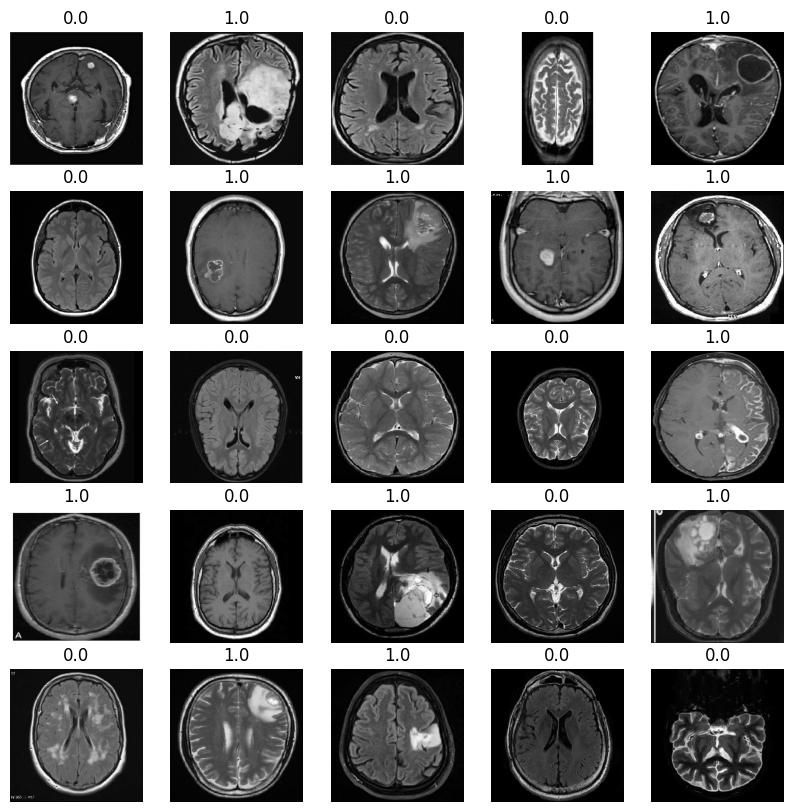

In [6]:
## Plot a sample from train_generator

import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_generator))

# Show 25 images
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i], cmap='gray')
    plt.title(str(label_batch[i][0].numpy()))
    plt.axis("off")

plt.show()



#### Tring a transfer learning approach

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
model = keras.Sequential([
    layers.Input(shape=(224, 224, 1)),
    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
    layers.MaxPool2D(2),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(2),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(2),

    # Classifier Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(units=64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(units=32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(units=1, activation="sigmoid"),
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
## Train the model
# Set the number of epochs
epochs = 100

# Set the early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# Set the model checkpoint criteria
# checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(train_generator, validation_data=test_generator, epochs=epochs, callbacks=[early_stopping])

# Save the model
# model.save('model.h5')


Epoch 1/100
6/6 [==============================] - 6s 717ms/step - loss: 0.6903 - accuracy: 0.5679 - val_loss: 0.7129 - val_accuracy: 0.6078
Epoch 2/100
6/6 [==============================] - 4s 689ms/step - loss: 0.6927 - accuracy: 0.5988 - val_loss: 0.9047 - val_accuracy: 0.6078
Epoch 3/100
6/6 [==============================] - 4s 676ms/step - loss: 0.6976 - accuracy: 0.5864 - val_loss: 0.7108 - val_accuracy: 0.6078
Epoch 4/100
6/6 [==============================] - 4s 672ms/step - loss: 0.6888 - accuracy: 0.5864 - val_loss: 0.6857 - val_accuracy: 0.6078
Epoch 5/100
6/6 [==============================] - 4s 673ms/step - loss: 0.6840 - accuracy: 0.5864 - val_loss: 0.7181 - val_accuracy: 0.6078
Epoch 6/100
6/6 [==============================] - 5s 751ms/step - loss: 0.6764 - accuracy: 0.5864 - val_loss: 0.6835 - val_accuracy: 0.6078
Epoch 7/100
6/6 [==============================] - 4s 686ms/step - loss: 0.6843 - accuracy: 0.5864 - val_loss: 0.6806 - val_accuracy: 0.6078
Epoch 8/100
6

In [59]:
model.evaluate(test_generator)

2/2 [==============================] - 1s 172ms/step - loss: 1.3871 - accuracy: 0.8627


[1.3870538473129272, 0.8627451062202454]

In [60]:
## Convert test generator to numpy array

test_generator_numpy = test_generator.as_numpy_iterator()
test_generator_numpy = np.array(list(test_generator_numpy))

X_test, y_test = np.concatenate(test_generator_numpy[:, 0]), np.concatenate(test_generator_numpy[:, 1])



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [61]:
## Calculate F1 and confusion matrix

from sklearn.metrics import f1_score, confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

f1_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)

2/2 [==============================] - 1s 153ms/step


array([[18,  2],
       [ 5, 26]], dtype=int64)

## Using LIME 

In [62]:
## Get all X_test and y_test with wrong prediction

X_test_wrong = X_test[y_test != y_pred.reshape(-1)]
y_test_wrong = y_test[y_test != y_pred.reshape(-1)]

X_test_right = X_test[y_test == y_pred.reshape(-1)]
y_test_right = y_test[y_test == y_pred.reshape(-1)]

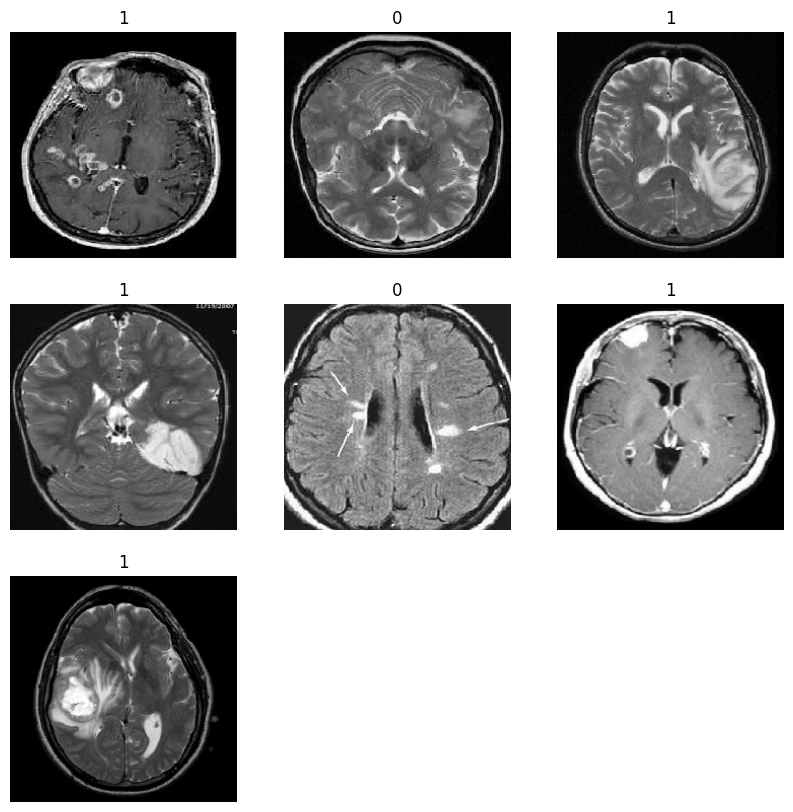

In [65]:
## Plot all wrong prediction

plt.figure(figsize=(10, 10))
for i in range(len(X_test_wrong)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_wrong[i], cmap='gray')
    plt.title(str(y_test_wrong[i]))
    plt.axis("off")

plt.show()

## XAI

In [66]:
## Using SHAP to explain the model
import shap
# Create an explainer object
explainer = shap.DeepExplainer(model, data=X_test)
for i in range(len(X_test_wrong)):
    # Get a sample the wrong prediction
    sample = X_test_wrong[i].reshape(1, 224, 224, 1)
    # Get the shap values
    shap_values = explainer.shap_values(sample)
    # Plot the shap values
    ## Add the original and probability of the wrong prediction
    shap.image_plot(shap_values, -sample, show=False)
    plt.title('Original: ' + str(y_test_wrong[i]))
    plt.show()




Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: in user code:

    File "c:\Users\GP65\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 252, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_LeakyRelu


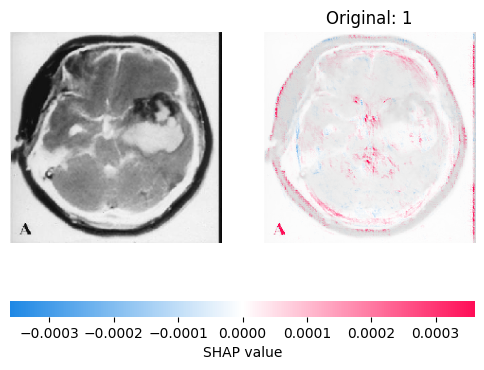

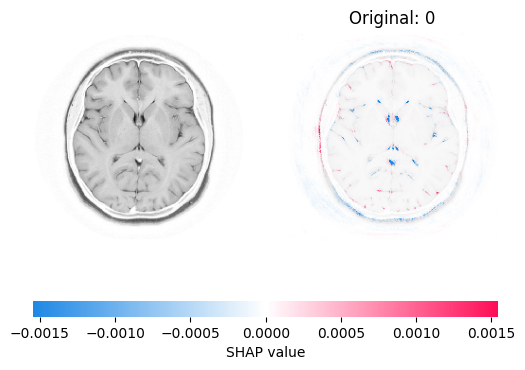

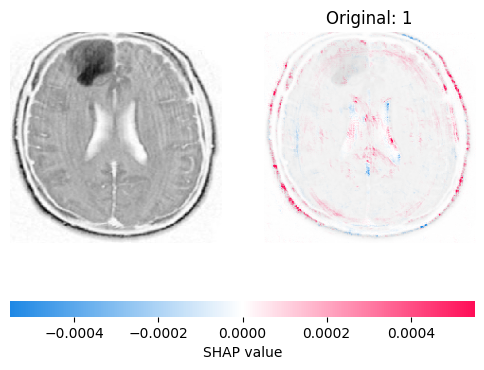

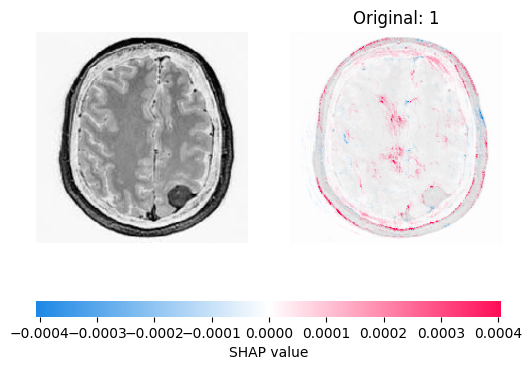

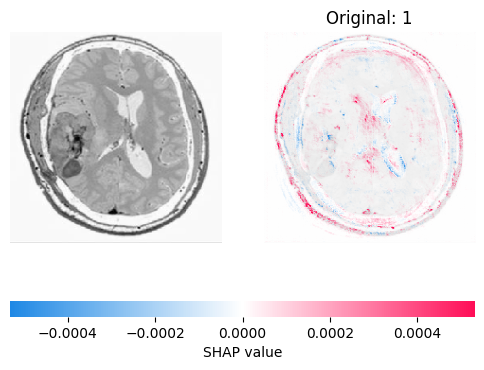

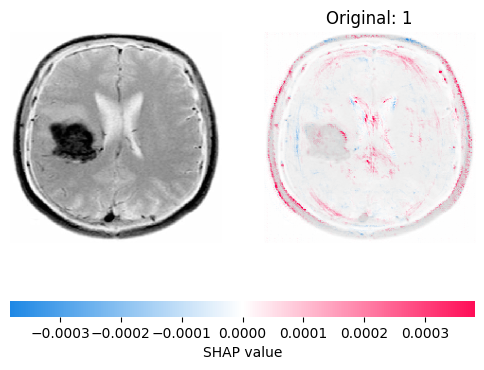

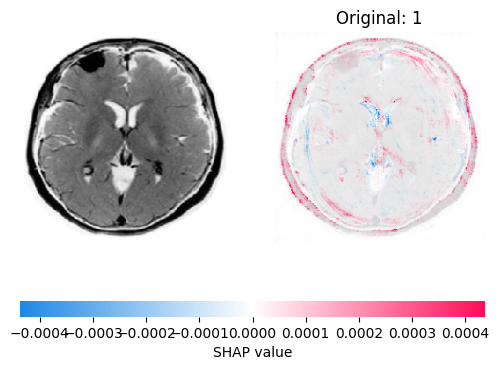

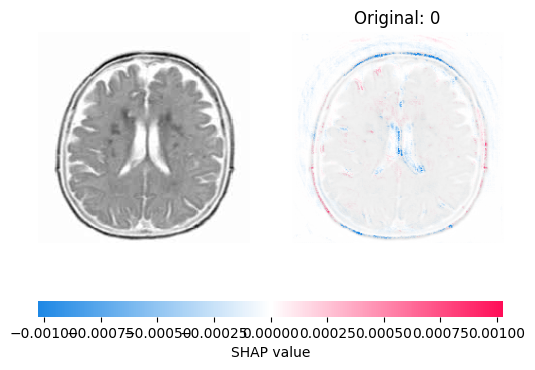

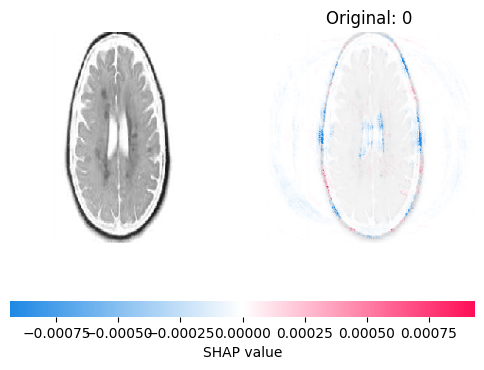

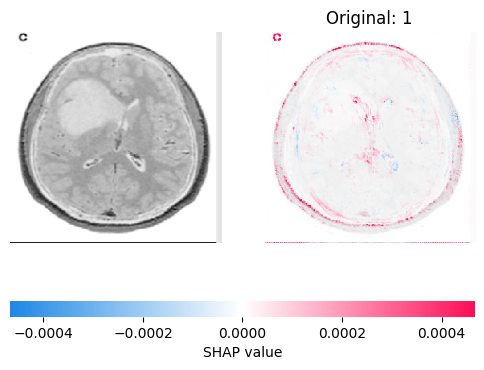

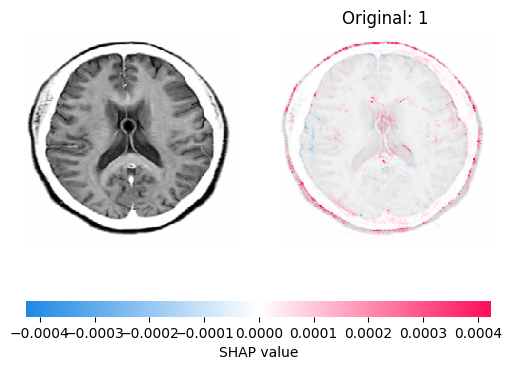

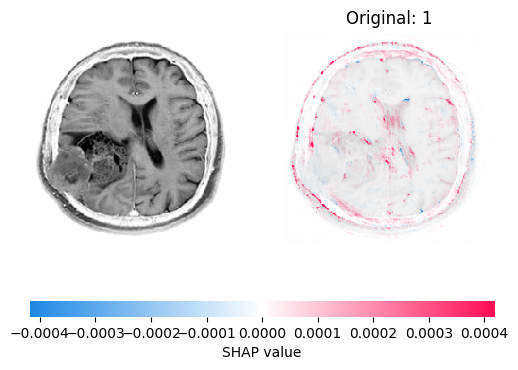

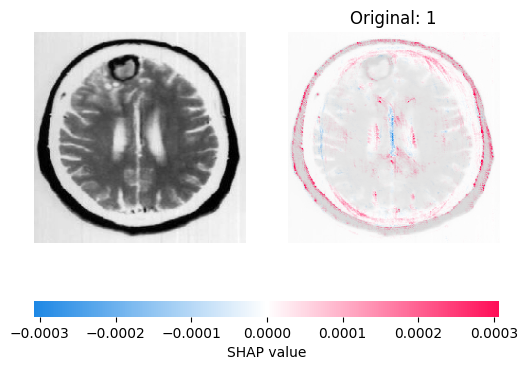

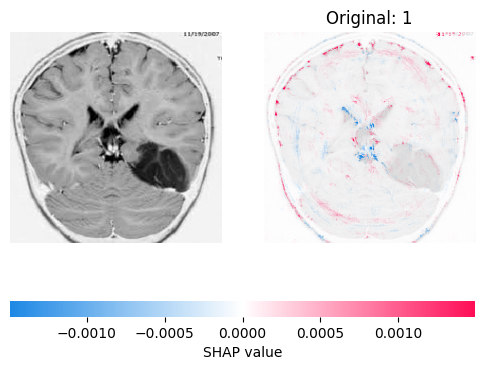

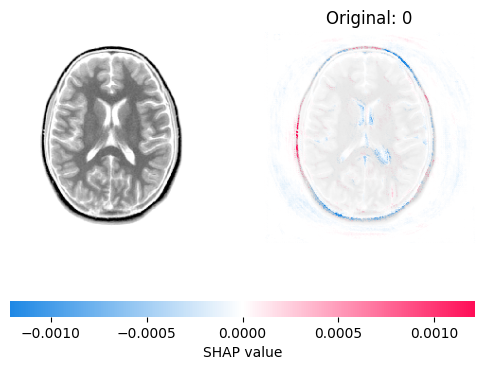

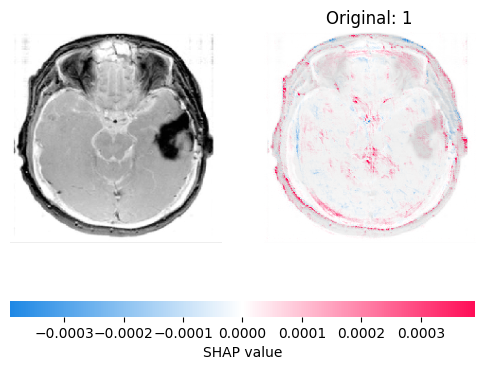

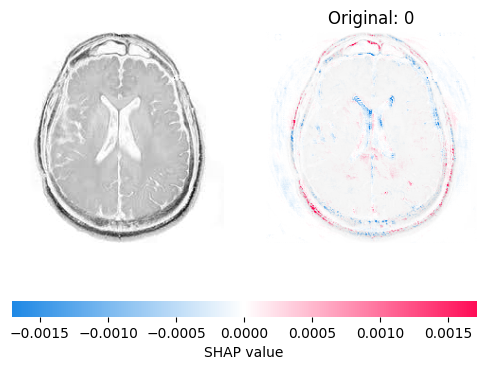

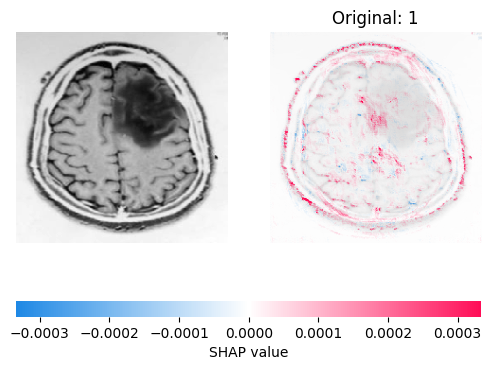

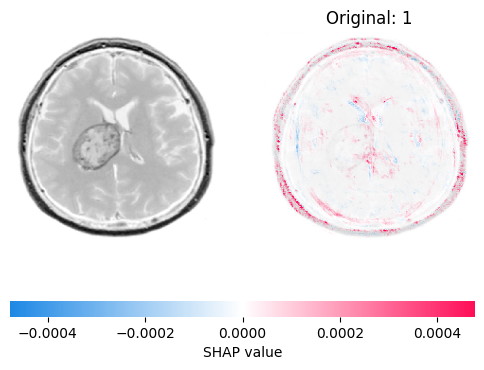

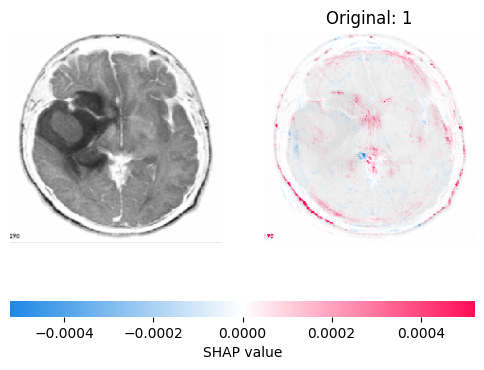

In [50]:
## Using SHAP to explain the model
import shap
# Create an explainer object
explainer = shap.DeepExplainer(model, data=X_test)
for i in range(len(X_test_right))[:20]:
    # Get a sample the wrong prediction
    sample = X_test_right[i].reshape(1, 224, 224, 1)
    # Get the shap values
    shap_values = explainer.shap_values(sample)
    # Plot the shap values
    ## Add the original and probability of the wrong prediction
    shap.image_plot(shap_values, -sample, show=False)
    plt.title('Original: ' + str(y_test_right[i]))
    plt.show()


